In [1]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. Será necesario incorporar características adicionales como el sentimiento o características léxicas.

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


**Nota 1**: El ejercicio propuesto es similar a los ejercicios de clasificación visto en clase, por lo que es importante que documentéis y expliquéis adecuadamente (con vuestras palabras) los procesos llevados a cabo en el ejercicio. No hacerlo puede llegar a penalizar hasta 1 punto en la calificación final.

**Nota 2**: Cualquier cálculo adicional a los vistos en clase (visualizaciones, nuevas características añadidas al modelo...) será valorado positivamente en la calificación.

## 0. Imports


In [90]:
import pandas as pd
import sys
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from textblob import TextBlob
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import TweetTokenizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import scipy as sp
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [3]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [4]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

In [5]:
print("Tenemos un conjunto de {} documentos".format(len(dataset)))
print("El dataframe tiene {} columnas".format(dataset.shape[1]))

Tenemos un conjunto de 47692 documentos
El dataframe tiene 2 columnas


#### En este dataset encontramos dos columnas diferentes:
    - La primera de ella con el texto de los tweets a analizar.
    - La segunda de ella con la clasificación en función de la identificación de actitudes negativas por motivo de raza, religión, edad, etnia etc. (0 si no se identifican actitudes negativas en el tweet, y 1 si se identifica esta actitud).

#### Buscamos duplicados y nulos dentro de nuestro DF.

In [6]:
print("Existen {} documentos duplicados en la columna de 'Tweet_text'".format(dataset.duplicated(subset=['tweet_text']).sum()))
print('Existen {} documentos duplicados en ambas columnas'.format(dataset.duplicated(subset=['tweet_text', 'cyberbullying']).sum()))
print("Hay {} valores vacíos en las noticias y {} valores vacíos en las etiquetas en los datos".format(
    dataset.isnull().sum()["tweet_text"],
    dataset.isnull().sum()["cyberbullying"]))

Existen 1675 documentos duplicados en la columna de 'Tweet_text'
Existen 166 documentos duplicados en ambas columnas
Hay 0 valores vacíos en las noticias y 0 valores vacíos en las etiquetas en los datos


#### Como podemos observar existen valores duplicados en ambas columnas (166) y tenemos valores duplicados únicamente en la columna 'tweet_text', esto significa que existen algunos tweets en los cuales la etiqueta toma ambos valores (existencia de cyberbullying y la no existencia de cyberbullying), en mi opinión esto es incongruente, por tanto, voy a eliminar todas las filas que tienen ambas etiquetas.

#### No existen nulos en ninguna de las filas

In [7]:
dataset = dataset.drop_duplicates(subset=["tweet_text", 'cyberbullying'], keep = 'first')

print("Después de la limpieza, quedan {} documentos".format(len(dataset)))

Después de la limpieza, quedan 47526 documentos


In [8]:
dataset = dataset.drop_duplicates(subset = ['tweet_text'], keep = False)
print('Después de eliminar todas las filas con ambas etiquetas, quedan {} documentos'.format(len(dataset)))

Después de eliminar todas las filas con ambas etiquetas, quedan 44508 documentos


#### Vamos a ver cuántos datos tenemos de cada categoría, recordamos que las categorías son:
    - 0: no existen actitudes negativas identificadas en sus tweets.
    - 1: se identifican actitudes negativas en sus tweets.

In [9]:
dataset.groupby(['cyberbullying']).count()

,tweet_text
cyberbullying,
0,6428
1,38080


#### Nuestras clasees están desbalanceadas, tenemos 38.000 tweets en los cuales se identifian actitudes negativas en los tweets, y 6.500 tweets donde no se identifican estas actitudes. Podemos observar más gráficamente este desbalanceo con un histograma donde se muestre el tamaño de cada una de las dos clases.

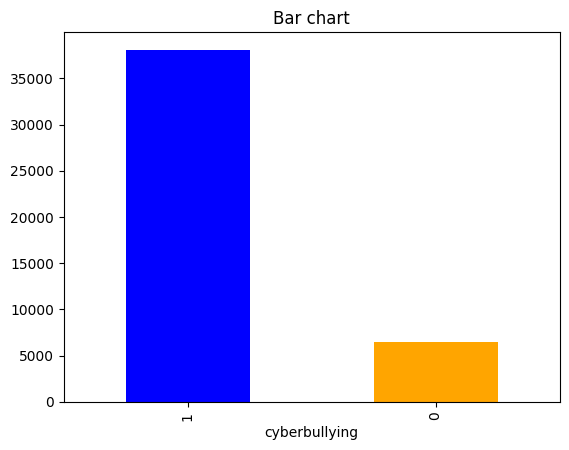

In [10]:
ax, fig = plt.subplots()
etiquetas = dataset.cyberbullying.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

#### Vamos a realizar un análisis de cómo se distribuyen los tweets en función de los caracteres.

<Figure size 1400x1200 with 0 Axes>

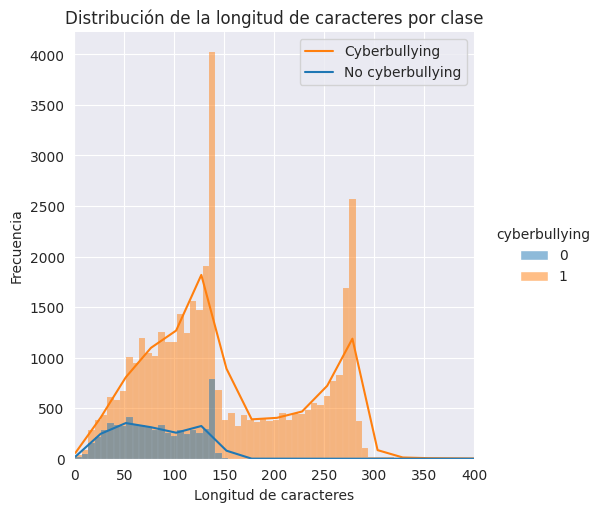

In [11]:
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset, x="char_len", hue="cyberbullying", kde=True, legend=True)

plt.legend(["Cyberbullying", "No cyberbullying"])
plt.title('Distribución de la longitud de caracteres por clase')
plt.xlabel('Longitud de caracteres')
plt.ylabel('Frecuencia')

plt.xlim(0, 400)

plt.show()

#### Como podemos observar los tweets que presentan actitudes de cyberbullying presentan más caracteres que los que no presentan estas actitudes.  Los tweets con cyberbullying tienen una amplitud máxima de 280 caracteres (máximo de la aplicación) y los tweets sin estas actitudes tienen un máximo de 150 caracteres.

#### Probablemente en este caso estemos viendo también una serie temporal, ya que twitter realizó una actualización en la cual se permitió aumentar la longitud de los tweets, me llama poderosamente la atención que, tras esta actualización (en la que se aumentaron los caracteres de 140 a 280 caracteres) solo encontremos tweets con cyberbullying, lo cual puede indicar que la muestra no está del todo bien seleccionada, que el etiquetado de los tweets sea incorrecto o que el cyberbullying a partir de esa fecha aumentó de manera drástica.

### Vamos a analizar qué contenido existe en cada una de las dos categorías identificadas en los tweets.

In [12]:
txt_cat0 = ",".join(dataset[dataset.cyberbullying==0].tweet_text.to_list())
txt_cat1 = ",".join(dataset[dataset.cyberbullying==1].tweet_text.to_list())

In [13]:
en_stopwords = stopwords.words('english')

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True)

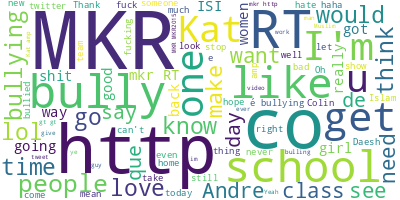

In [14]:
wordcloud.generate(txt_cat0)
wordcloud.to_image()

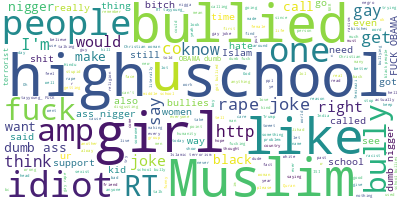

In [15]:
wordcloud.generate(txt_cat1)
wordcloud.to_image()

#### Como podemos observar:
    -En el caso del etiquetado 0 de cyberbullying las palabras que encontramos no referencian cyberbullying a exceptción de la palabra bully, encontramos que el peso de la palabra HTTPS es bastante elevado, lo que nos indica que en este tipo de tweets se adjuntan URL.
    -Con respecto a las palabras más repetidas en el caso de la etiqueta con cyberbullying, las palabras que encontramos tienen un marcado caracter de acoso, ya que se repiten insultos, se habla de la religión musulmana etc.

### Analizamos la presencia de emojis en los tweets.

In [16]:
def has_emoji(text):
    emojis = re.findall(r'[^\w\s,]', text)
    return len(emojis) > 0

In [17]:
dataset['emoji'] = dataset['tweet_text'].apply(has_emoji)

In [19]:
filas_con_icono = dataset[dataset['emoji'] == True]

filas_con_icono_y_cyberbullying_1 = filas_con_icono[filas_con_icono['cyberbullying'] == 1]['tweet_text'].to_list()

filas_con_icono_y_cyberbullying_0 = filas_con_icono[filas_con_icono['cyberbullying'] == 0]['tweet_text'].to_list()

In [20]:
filas_con_icono_y_cyberbullying_1 = [item for sublist in filas_con_icono_y_cyberbullying_1 for item in sublist]
filas_con_icono_y_cyberbullying_0 = [item for sublist in filas_con_icono_y_cyberbullying_0 for item in sublist]

In [21]:
def extraer_emojis(texto):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "]+"
    )
    return emoji_pattern.findall(texto)

emojis1 = []
for tweet in filas_con_icono_y_cyberbullying_1:
    emojis1.extend(extraer_emojis(tweet))

emojis0 = []
for tweet in filas_con_icono_y_cyberbullying_0:
    emojis0.extend(extraer_emojis(tweet))

In [22]:
contador_emojis1 = Counter(emojis1)

emojis_mas_usados1 = contador_emojis1.most_common(5)
print("Emojis más usados en tweets con cyberbullying:", emojis_mas_usados1)

contador_emojis0 = Counter(emojis0)

emojis_mas_usados0 = contador_emojis0.most_common(5)
print("Emojis más usados en tweets sin cyberbullying:", emojis_mas_usados0)

Emojis más usados en tweets con cyberbullying: [('😂', 37), ('😘', 37), ('😊', 8), ('😳', 6), ('😩', 6)]
Emojis más usados en tweets sin cyberbullying: [('😂', 28), ('😊', 14), ('😍', 11), ('😁', 9), ('😡', 9)]


#### No vemos una relación entre tweets con cyberbullying y emojis relacionados con odio, de hecho, los tweets empleados entre ambos tipos de tweets son bastantes similares.

#### Curiosamente en las etiquetas de sin cyberbullying encontramos que el quinto emoji más común es una cara de enfado, lo cual puede estar más relacionado con actitudes de cyberbullying que los emjis más comunes del conjunto de datos etiquetados como con cyberbullying.

## 3. Preprocesado y Normalización

In [23]:
# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

In [24]:
# Espacios
tqdm.pandas()
dataset["normalized"] = dataset["tweet_text"].progress_apply(lambda x: eliminar_espacios(x))
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: texto_to_lower(x))

100%|██████████| 44508/44508 [00:00<00:00, 585912.99it/s]


In [25]:
# Tokenizador
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(documento):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

In [26]:
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: normalizar_tokens(x))

100%|██████████| 44508/44508 [00:09<00:00, 4735.59it/s]


In [27]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lematizar_eliminacion_tokens(texto):
    # Procesar el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizar el texto
    lemas = [token.lemma_ for token in doc]

    # Eliminar símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in en_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado

In [28]:
dataset["preprocessed_text"] = dataset["normalized"].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

100%|██████████| 44508/44508 [04:39<00:00, 159.52it/s]


#### Sacamos los nuevos wordcloud tras el preprocesado.

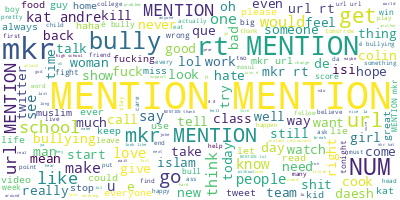

In [29]:
txt_cat0 = ",".join(dataset[dataset.cyberbullying==0].preprocessed_text.to_list())
txt_cat1 = ",".join(dataset[dataset.cyberbullying==1].preprocessed_text.to_list())
# Genera el wordcloud
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

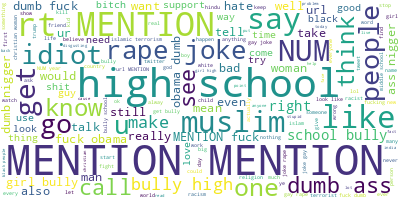

In [30]:
# Genera el wordcloud
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()

#### Tras el preprocesado observamos en los wordcloud lo mismo que antes del preprocesado, encontramos más palabras relacionadas con el cyberbullying en el etiquetado correspondiente al cyberbullying.

#### También observamos en los dos wordclouds que se repite mucho la palabra mention, es decir, parece que se sigue un hilo de conversación o que se menciona a diferentes personas, podemos realizar una función donde saquemos cuántas veces se repite el valor de mention.

In [68]:
def token_appearance(document, token = "MENTION"):
  return len([x for x in document.split() if x == token])

def token_appearance2(document, token="URL"):
  return len([x for x in document.split() if x == token])

In [69]:
dataset["num_mention"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="MENTION"))
dataset["num_URLS"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance2(x, token="URL"))

100%|██████████| 44508/44508 [00:00<00:00, 111611.05it/s]


In [70]:
dataset[['num_mention','cyberbullying']].value_counts()

num_mention  cyberbullying
0            1                25223
1            1                 8910
0            0                 3287
2            1                 2551
1            0                 2296
3            1                  896
2            0                  500
4            1                  297
3            0                  175
5            1                  109
4            0                   79
5            0                   48
6            1                   46
7            1                   23
8            0                   15
6            0                   14
7            0                   12
8            1                    8
10           1                    6
9            1                    5
17           1                    2
10           0                    1
12           1                    1
16           0                    1
30           1                    1
42           1                    1
51           1                    1
N

#### Podemos observar que los tweets con actitudes de cyberacoso presentan más interacciones que los tweets sin cyberacoso, eso puede indicar que tienen una repercusión mayor dentro de la propia RRSS.

In [71]:
dataset[['num_URLS','cyberbullying']].value_counts()

num_URLS  cyberbullying
0         1                37372
          0                 6203
1         1                  701
          0                  221
2         0                    4
          1                    4
3         1                    1
4         1                    1
8         1                    1
Name: count, dtype: int64

#### Presentan más número de URL los tweets con características de cyberacoso que los tweets sin cyberacoso.

In [72]:
dataset["tweet_sentiment_polarity"] = dataset["preprocessed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
dataset["tweet_sentiment_subjectivity"] = dataset["preprocessed_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [36]:
dataset[['tweet_sentiment_polarity','cyberbullying']].value_counts()

tweet_sentiment_polarity  cyberbullying
 0.000000                 1                6375
                          0                3210
-0.387500                 1                1343
-0.800000                 1                1028
 0.160000                 1                 851
                                           ... 
 0.015333                 1                   1
-0.185185                 1                   1
 0.015278                 1                   1
                          1                   1
-0.001061                 1                   1
Name: count, Length: 7365, dtype: int64

In [37]:
dataset[['tweet_sentiment_subjectivity','cyberbullying']].value_counts()

tweet_sentiment_subjectivity  cyberbullying
0.000000                      1                5287
                              0                2947
0.550000                      1                1606
1.000000                      1                1017
0.800000                      1                1013
                                               ... 
0.464583                      1                   1
0.464667                      1                   1
0.464683                      1                   1
0.464921                      1                   1
0.503846                      1                   1
Name: count, Length: 5506, dtype: int64

#### Con respecto a la polaridad y la subjetividad:
  - Polaridad: los tweets sin cyberacoso presentan sentimientos neutros (es decir, no están polarizados), sin embargo, en los tweets con cyberacoso si encontramos sentimientos polarizados, especialmente negativos.
  -Subjetividad: los tweets sin cyberacos no son subjetivos, si encontramos esta subjetividad en tweets con cyberacoso.

#### No sacamos una columna con el caracter positivo/negativo/neutro de los emojis ya que, al ser iguales en ambas etiquetas, considero que no va a proporcionar información adicional.

## 4. Vectorización

In [73]:
vectorizador = TfidfVectorizer(lowercase = False, stop_words =None,
                               min_df=0.005, ngram_range = (1,3))

vector_data = vectorizador.fit_transform(dataset["preprocessed_text"])

In [74]:
vector_data

<44508x420 sparse matrix of type '<class 'numpy.float64'>'
	with 378881 stored elements in Compressed Sparse Row format>

In [46]:
dataset

,tweet_text,cyberbullying,char_len,emoji,normalized,preprocessed_text,num_mention,num_URLS,tweet_sentiment_polarity,tweet_sentiment_subjectivity
0,"In other words #katandandre, your food was cra...",0,61,True,"in other words #katandandre , your food was cr...",word katandandre food crapilicious mkr,0,0,0.000000,0.000000
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,True,why is #aussietv so white ? #mkr #theblock #im...,aussietv white mkr theblock imacelebrityau tod...,0,0,0.000000,0.000000
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,True,MENTION a classy whore ? or more red velvet cu...,MENTION classy whore red velvet cupcake,1,0,0.050000,0.450000
4,@RudhoeEnglish This is an ISIS account pretend...,0,103,True,MENTION this is an isis account pretending to ...,MENTION isis account pretend kurdish account l...,1,0,0.000000,0.000000
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",0,131,True,"MENTION MENTION yes , the test of god is that ...",MENTION MENTION yes test god good bad indiffer...,2,0,-0.166667,0.755556
...,...,...,...,...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",1,234,True,"black ppl aren't expected to do anything , dep...",black ppl expect anything depend anything yet ...,0,0,-0.002083,0.276042
47688,Turner did not withhold his disappointment. Tu...,1,276,True,turner did not withhold his disappointment . t...,turner withhold disappointment turner call cou...,0,0,-0.466667,0.433333
47689,I swear to God. This dumb nigger bitch. I have...,1,104,True,i swear to god . this dumb nigger bitch . i ha...,swear god dumb nigger bitch get bleach hair re...,0,0,-0.387500,0.550000
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,1,90,True,yea fuck you rt MENTION : if youre a nigger fu...,yea fuck rt MENTION nigger fucking unfollow fu...,1,0,-0.458333,0.633333


In [75]:
extra_features = dataset[['num_mention','num_URLS',
                          'tweet_sentiment_subjectivity','tweet_sentiment_polarity']]

In [76]:
y = dataset["cyberbullying"].values.astype(np.float32)
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')

In [77]:
X_columns=list(vectorizador.get_feature_names_out())+extra_features.columns.tolist()

#### Puesto que los datos están desbalanceados, vamos a balancear los datos.

In [78]:
#Establecemos el tamaño de x_train, y_train, x_test e y_test para poder evaluar posteriormente la precisión de nuestro modelo.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(33381, 424)
(11127, 424)


In [79]:
sm = SMOTE(random_state=42)
#Renombramos X e Y para entrenar el modelo con los datos rebalanceados
X_res, y_res = sm.fit_resample(X_train, y_train)

In [80]:
np.array(np.unique(y_res, return_counts=True)).T

array([[0.000e+00, 2.857e+04],
       [1.000e+00, 2.857e+04]])

## 5. Entrenamiento y evaluación de modelos


#### Lo primero que vamos a hacer es mirar qué modelo es el que mejor se adapta a los datos que tenemos.

In [81]:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      for name, model in models:
          warnings.filterwarnings('ignore')
          KF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 98)

          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          results.append(cv_results)
          names.append(name)

          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [82]:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_res.toarray(), y_res)

Metric: accuracy , KFold 
Logistic: 0.878264 (0.001529) 
Metric: accuracy , KFold 
GaussianNB: 0.816258 (0.001962) 


([array([0.8780189 , 0.87775639, 0.87941897, 0.87583129, 0.88029401]),
  array([0.81274064, 0.81641582, 0.81877844, 0.81641582, 0.81694085])],
 ['Logistic', 'GaussianNB'])

#### Vemos que el modelo Logistic tiene unas métricas mejores, tanto en accuracy como en la validación cruzada.

In [83]:
#Definimos tanto el modelo como los parámetros.
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [84]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=10)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [85]:
grid_result = grid_search.fit(X_res, y_res)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.869636 usando los parámetros {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


#### Entrenamos el modelo con los hiperparámetros obtenidos.

In [87]:
model=LogisticRegression(C=10, penalty="l2", solver = "newton-cg")
model.fit(X_res,y_res)

LogisticRegression(C=10, solver='newton-cg')

In [88]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1321  296]
 [1693 7817]]
              precision    recall  f1-score   support

         0.0       0.44      0.82      0.57      1617
         1.0       0.96      0.82      0.89      9510

    accuracy                           0.82     11127
   macro avg       0.70      0.82      0.73     11127
weighted avg       0.89      0.82      0.84     11127



#### El modelo tiene muy buena predicción para los tweets con cyberacoso pero no muy buena para los tweets sin cyberacoso, las métricas mejoran al observar el recall de los tweets.